In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, calinski_harabasz_score, silhouette_score, mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
# bayestian hyperparameter tunning
import optuna
# models to try
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost

from myvars import input_features
from myfuncs import num_describe, generate_features
from myclasses import Windsorizer


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Simulate future data

In [2]:
def separate_data(to_csv = True):
    data = pd.read_csv('../data/processed/data.csv')
    data = data.dropna(subset=input_features)
    data = generate_features(data)
    future = data.query("calendarYear > 2018")
    present = data.query("calendarYear <= 2018")
    if to_csv:
        future.to_csv('../data/processed/future.csv', index=False)
        present.to_csv('../data/processed/present.csv', index=False)
    return present, future

In [3]:
present, future = separate_data()

c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[feature_name] = data[col]/data.revenue
c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[feature_name] = data[col]/data.revenue
c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

# v1

## Try different models

In [4]:
data = pd.read_csv('../data/processed/present.csv')
to_drop = ['target', 'symbol', 'calendarYear', 'fillingDate', 'targetYoY']
features = data.drop(columns=to_drop)
target = data.target

#### Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    np.log(target), 
    test_size=0.25, 
    random_state = 46)
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(4738, 142), (1580, 142), (4738,), (1580,)]

In [9]:
pd.concat([X_train,y_train], axis=1).to_csv('../data/processed/train.csv', index=False)
pd.concat([X_test,y_test], axis=1).to_csv('../data/processed/test.csv', index=False)

#### Hyperparameter search functions

In [40]:
def print_regression_metrics(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    # mean absolute error
    print('train mae: ', mean_absolute_error(y_true=y_train, y_pred=train_preds))
    print('test mae: ', mean_absolute_error(y_true=y_test, y_pred=test_preds))
    # mean sqared error
    print('train mse: ', mean_squared_error(y_true=y_train, y_pred=train_preds))
    print('test mse: ', mean_squared_error(y_true=y_test, y_pred=test_preds))
    # r2
    print('train r2: ', r2_score(y_true=y_train, y_pred=train_preds))
    print('test r2: ', r2_score(y_true=y_test, y_pred=test_preds))
    return None

In [11]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [20]:
def do_poly_regression(pipe, X_train, X_test, y_train, y_test=None, degree = 2):
    pipe.steps.append(('poly_transform', PolynomialFeatures(degree=degree)))
    pipe.steps.append(('regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mae_test = mean_absolute_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('mae test: ', mae_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

In [22]:
def do_linear_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_svm', LinearSVR(C=0.02, max_iter=1000)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [76]:
def do_svm_regression(pipe, C, epsilon, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rbf_svm', SVR(kernel = 'rbf', C=C, epsilon=epsilon)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

In [73]:
def do_neighbors(X_train, X_test, y_train, y_test=None):
    def objective(trial):
        n_features_to_select = trial.suggest_int("n_features_to_select", 1, 10)
        knn_params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 10),
        }
        pipe = Pipeline(steps=[
            ('RFE', RFE(estimator = LinearRegression(), n_features_to_select=n_features_to_select)),
            ('KNN', KNeighborsRegressor(**knn_params)),
        ])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        mae = mean_absolute_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mae
    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [ ]:
def search_forest(X_train, X_test, y_train, y_test):
    def objective(trial):
        params={
            "min_samples_leaf": trial.suggest_float("min_samples_leaf", 1e-4, 0.1, log=True),
            "min_samples_split": trial.suggest_float("min_samples_split", 1e-4, 0.1, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('forest', RandomForestRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mae = mean_absolute_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mae
    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [45]:
def search_boosting(pipe, X_train, X_test, y_train, y_test):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', xgboost.XGBRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mae = mean_absolute_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mae

    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

#### No model

In [ ]:
n = len(y_test)
mean = y_train.mean()
worst_preds = np.tile(mean, n)
mean_squared_error(y_true=np.exp(y_test), y_pred = np.exp(worst_preds))

5707.939841566766

#### Linear Regression

In [12]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, X_train, X_test, y_train, y_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 747.5483154311172
mse test:  890.8550824407577
rmse test:  29.84719555403418


#### Polynomial Regression

In [21]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_poly_regression(mypipe, X_train, X_test, y_train, y_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\fpala\AppData\Local\Temp\ipykernel_5232\2005814906.py:7: RuntimeWarning: overflow encountered in exp
  mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

- **Insane Overfit**. 1e113 order of magnitude. 

#### Linear SVR

In [23]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_svm_regression(mypipe, X_train, X_test, y_train, y_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 660.4220398735827
mse test:  839.0626943957653
rmse test:  28.96657892115956


C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


- Check ill-conditioning. For C's larger than 0.02 it stops converging despite max_iter being 1000

#### SVM with radial basis functions

In [84]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_svm_regression(mypipe, 0.5, 0.01, X_train, X_test, y_train, y_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 626.9985052339703
mse test:  716.3309840963284
rmse test:  26.764360334151988


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rbf_svm', SVR(C=0.5, epsilon=0.01))])

#### KNN

In [74]:
results, study = do_neighbors(X_train, X_test, y_train, y_test)

[I 2022-04-21 02:07:39,992] A new study created in memory with name: no-name-1e73cdc0-97ea-4886-9582-0cde6f25ad81
[I 2022-04-21 02:07:45,865] Trial 0 finished with value: 30.72272136094757 and parameters: {'n_features_to_select': 10, 'n_neighbors': 6}. Best is trial 0 with value: 30.72272136094757.
[I 2022-04-21 02:07:51,488] Trial 1 finished with value: 31.228291805113432 and parameters: {'n_features_to_select': 5, 'n_neighbors': 10}. Best is trial 0 with value: 30.72272136094757.
[I 2022-04-21 02:07:57,128] Trial 2 finished with value: 30.16034774596865 and parameters: {'n_features_to_select': 9, 'n_neighbors': 9}. Best is trial 2 with value: 30.16034774596865.
[I 2022-04-21 02:08:02,802] Trial 3 finished with value: 32.12032163636089 and parameters: {'n_features_to_select': 1, 'n_neighbors': 4}. Best is trial 2 with value: 30.16034774596865.
[I 2022-04-21 02:08:08,440] Trial 4 finished with value: 30.84033447930174 and parameters: {'n_features_to_select': 6, 'n_neighbors': 8}. Best 

KeyboardInterrupt: 

- ok

#### Random Forest
- Including some basic hyperparameter tunning trying skopt interface for BayesSearch

In [31]:
results, study = search_forest(mypipe, X_train, X_test, y_train, y_test)

[I 2022-04-21 01:04:08,227] A new study created in memory with name: no-name-12ab3925-2c28-4c36-93a1-0fa819a90811
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-21 01:04:34,510] Trial 0 finished with value: 7.71841064819289 and parameters: {'min_samples_leaf': 0.0008700785108801795, 'min_samples_split': 0.005962312727716521, 'max_depth': 5}. Best is trial 0 with value: 7.71841064819289.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-21 01:05:03,802] Trial 1 finished with value: 7.802276044978692 and parameters: {'min_samples_leaf': 0.00294845427924611, 'min_samples_split': 0.02311328052106981, 'max_depth': 6}. Best is trial 0 with value: 7.7184

In [35]:
study.best_value, study.best_params

(7.157587455311358,
 {'min_samples_leaf': 0.002887236335925434,
  'min_samples_split': 0.00028915198115079827,
  'max_depth': 10})

In [36]:
rf_params = {'min_samples_leaf': 0.002887236335925434,
  'min_samples_split': 0.00028915198115079827,
  'max_depth': 10}
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=0.002887236335925434,
                      min_samples_split=0.00028915198115079827)

In [41]:
print_regression_metrics(rf, X_train, X_test, y_train, y_test)

train mae:  0.14301087444730531
test mae:  0.19174548816877543
train mse:  0.04841224660723916
test mse:  0.0817713044918034
train r2:  0.9616287448773119
test r2:  0.9348401392200132


#### Gradient Boosting

In [46]:
results, study = search_boosting(mypipe, X_train, X_test, y_train, y_test)
study.best_value, study.best_params

[I 2022-04-21 01:20:20,480] A new study created in memory with name: no-name-13e633df-a134-4b09-b51a-2a351e713017
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-21 01:20:23,643] Trial 0 finished with value: 15.479536715980968 and parameters: {'min_child_weight': 308, 'alpha': 1.0266312728655537e-05, 'max_depth': 10, 'colsample_bytree': 0.5013729850181415, 'subsample': 0.6046647150456191, 'eta': 0.027218017559716326}. Best is trial 0 with value: 15.479536715980968.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-21 01:20:27,963] Trial 1 finished with value: 9.24965618814514 and parameters: {'min_child_weight': 323, 'alpha': 0.0001106594593129271,

(5.971772216546079,
 {'min_child_weight': 21,
  'alpha': 8.464262824000469e-06,
  'max_depth': 6,
  'colsample_bytree': 0.9568303973200649,
  'subsample': 0.9991474262343963,
  'eta': 0.12082260645131745})

In [ ]:
xgb_params = {'min_child_weight': 21,
  'alpha': 8.464262824000469e-06,
  'max_depth': 6,
  'colsample_bytree': 0.9568303973200649,
  'subsample': 0.9991474262343963,
  'eta': 0.12082260645131745}
xgbr = xgboost.XGBRegressor(**xgb_params)

#### Asses Results

In [72]:
# Linear Regression predictions
lr_pipe = make_pipeline(PowerTransformer(), LinearRegression())
# SVM
svm_pipe = make_pipeline(PowerTransformer(), SVR(C=0.5, epsilon=0.1))
# Neighbors = 10, 10
knn_pipe = make_pipeline(PowerTransformer(), RFE(estimator=LinearRegression(), n_features_to_select=10), KNeighborsRegressor(10))
# Random Forest
rf_params = {'min_samples_leaf': 0.002887236335925434,
  'min_samples_split': 0.00028915198115079827,
  'max_depth': 10}
rf_pipe = make_pipeline(PowerTransformer(), RandomForestRegressor(**rf_params))
# XGBoost 
xgb_params = {'min_child_weight': 21,
  'alpha': 8.464262824000469e-06,
  'max_depth': 6,
  'colsample_bytree': 0.9568303973200649,
  'subsample': 0.9991474262343963,
  'eta': 0.12082260645131745}
xgb_pipe = make_pipeline(PowerTransformer(), xgboost.XGBRegressor(**xgb_params))

In [7]:
results = data.loc[X_test.index,:]
for name, estimator in [('lr',lr_pipe), ('svm',svm_pipe), ('knn',knn_pipe), ('rf',rf_pipe), ('xgb',xgb_pipe)]:
    estimator.fit(X_train, y_train)
    results[name] = np.exp(estimator.predict(X_test))

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
 

In [8]:
cols = ['target','lr', 'svm', 'knn', 'rf', 'xgb']
results.loc[:,cols].corr()

,target,lr,svm,knn,rf,xgb
target,1.00000,0.93728,0.93516,0.90064,0.96160,0.97828
lr,0.93728,1.00000,0.90058,0.92576,0.93626,0.94933
svm,0.93516,0.90058,1.00000,0.87323,0.90869,0.93968
knn,0.90064,0.92576,0.87323,1.00000,0.93769,0.92907
rf,0.96160,0.93626,0.90869,0.93769,1.00000,0.98706
xgb,0.97828,0.94933,0.93968,0.92907,0.98706,1.00000


<AxesSubplot:>

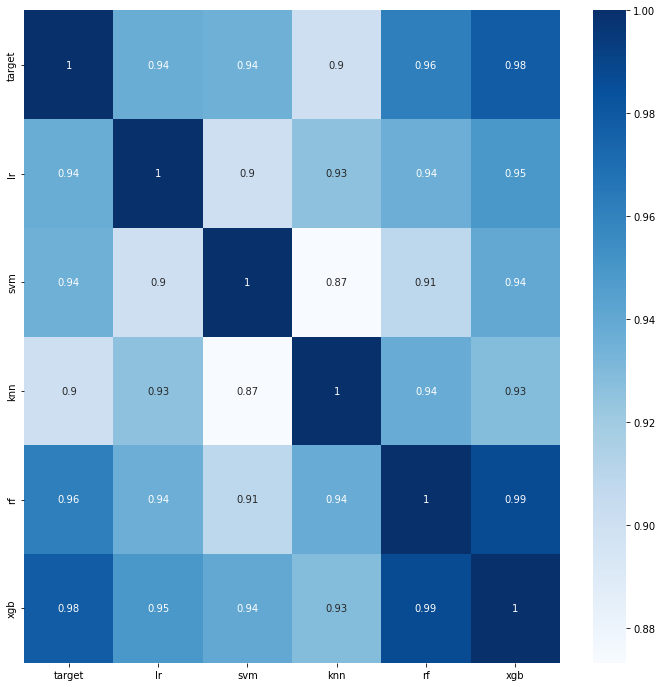

In [9]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
sns.heatmap(results.loc[:,cols].corr(), annot=True, cmap = 'Blues')

#### Try on Future Data

In [10]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=to_drop)
future_target = future_data.target
future_features.shape, future_target.shape

((1494, 142), (1494,))

In [11]:
for name, estimator in [('lr',lr_pipe), ('svm',svm_pipe), ('knn',knn_pipe), ('rf',rf_pipe), ('xgb',xgb_pipe)]:
    future_data[name] = np.exp(estimator.predict(future_features))

In [12]:
future_data.loc[:,cols].corr()

,target,lr,svm,knn,rf,xgb
target,1.00000,0.67782,0.46014,0.67863,0.85828,0.87793
lr,0.67782,1.00000,0.26031,0.58128,0.63574,0.64761
svm,0.46014,0.26031,1.00000,0.53948,0.59709,0.58961
knn,0.67863,0.58128,0.53948,1.00000,0.85698,0.84410
rf,0.85828,0.63574,0.59709,0.85698,1.00000,0.99163
xgb,0.87793,0.64761,0.58961,0.84410,0.99163,1.00000


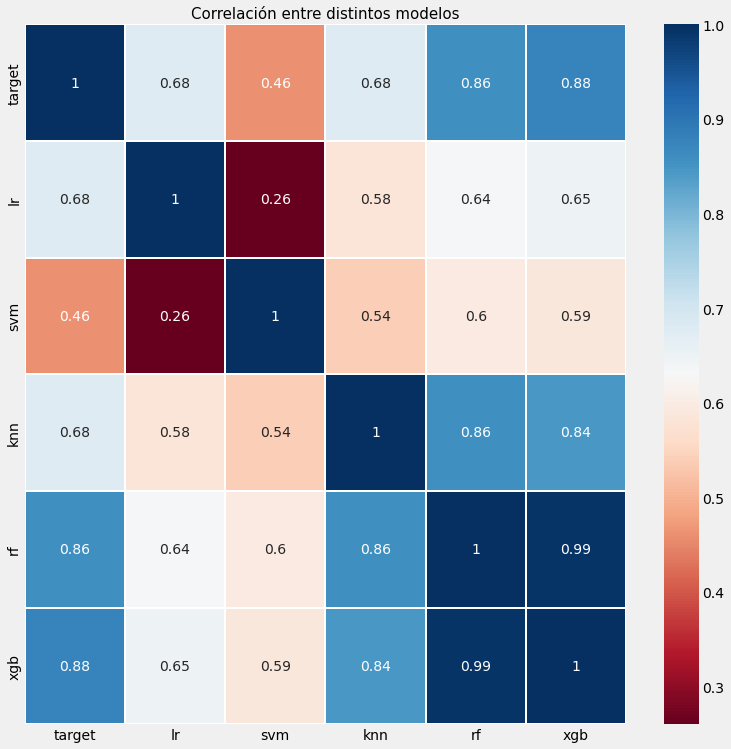

In [14]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (12,12))
sns.heatmap(future_data.loc[:,cols].corr(), annot=True, cmap = 'RdBu', linewidths=0.1)
ax.set_title('Correlación entre distintos modelos', fontsize = 15)
plt.savefig('../../ppt/images/corr_modelos.jpg', bbox_inches = 'tight')

In [15]:
for col in ['lr', 'svm', 'knn', 'rf', 'xgb']:
    print('-'*40)
    print(col)
    print(mean_absolute_error(y_true=future_data.target, y_pred=future_data[col]))
    print(r2_score(y_true=future_data.target, y_pred=future_data[col]))
    print(mean_squared_error(y_true=future_data.target, y_pred=future_data[col]))

----------------------------------------
lr
28.43412862898581
0.39112828105351505
19874.173750447684
----------------------------------------
svm
48.40353006092139
0.04014641514941797
31330.568207894055
----------------------------------------
knn
39.348801623682725
0.1960553215843771
26241.54764853546
----------------------------------------
rf
21.129691082979967
0.5968794103183972
13158.253852843614
----------------------------------------
xgb
20.22228551043372
0.6309980052720815
12044.589244797884


##### Linear Regression

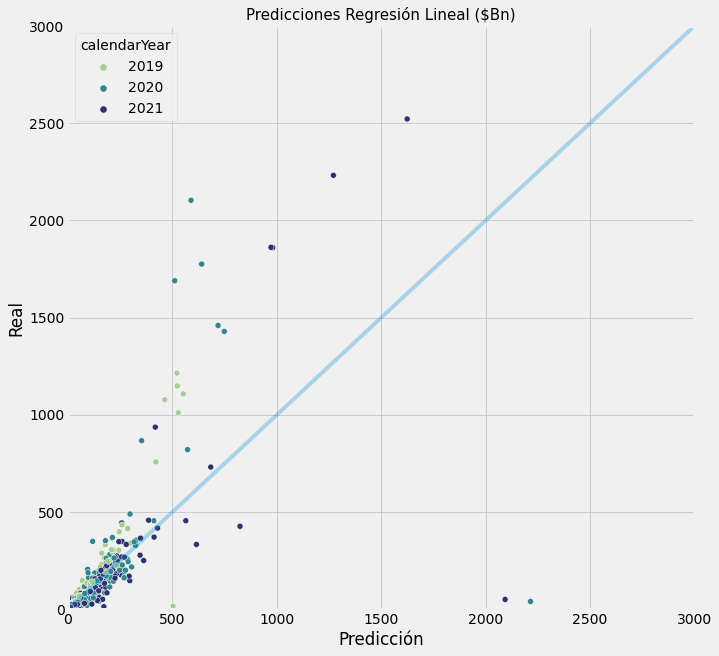

In [82]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='lr',hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
ax.set_title('Predicciones Regresión Lineal ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.axis([0, 3000, 0, 3000])
plt.savefig('../../ppt/images/linear_regresision.jpg', bbox_inches = 'tight')

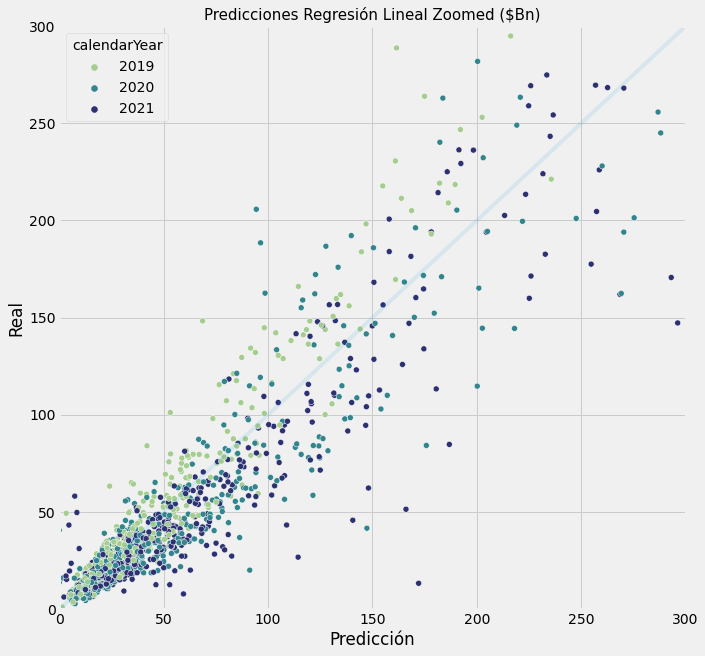

In [91]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='lr', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.1)
plt.axis([0, 300, 0, 300])
ax.set_title('Predicciones Regresión Lineal Zoomed ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/linear_regresision_zoomed.jpg', bbox_inches = 'tight')

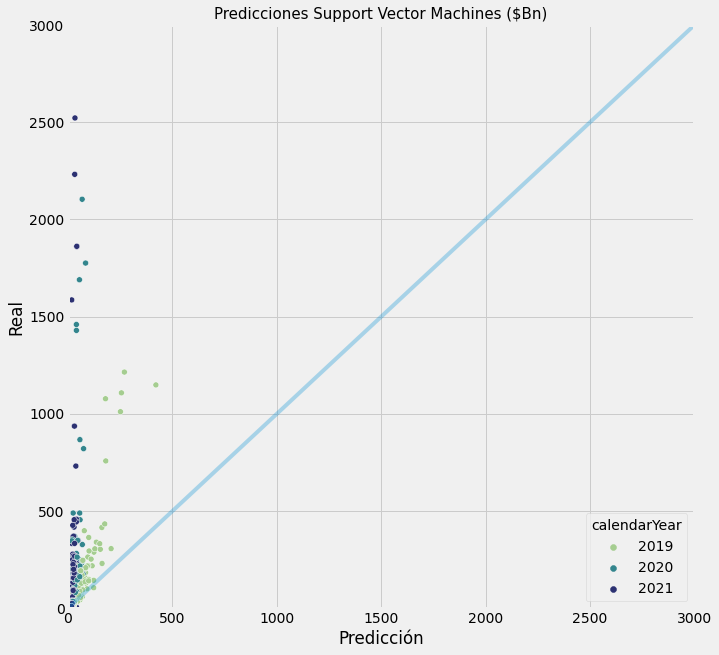

In [84]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='svm', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 3000, 0, 3000])
ax.set_title('Predicciones Support Vector Machines ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/svm.jpg', bbox_inches = 'tight')

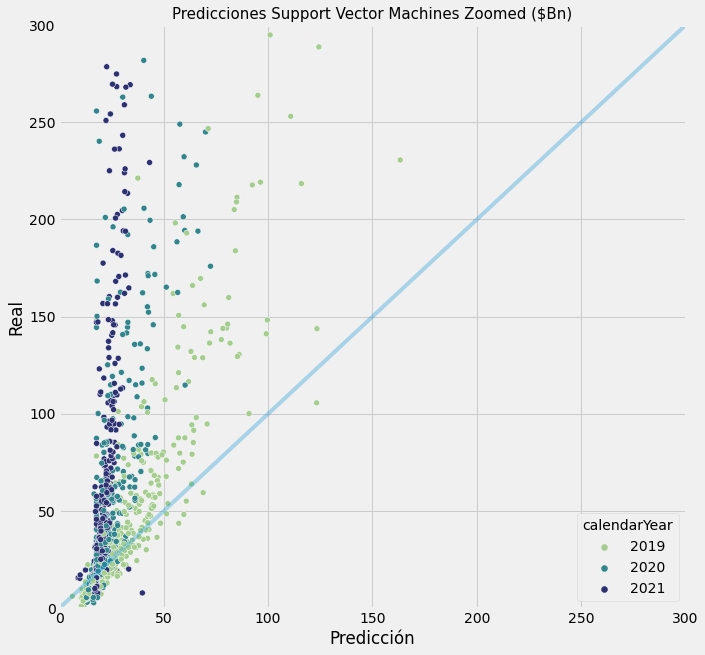

In [92]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='svm', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 300, 0, 300])
ax.set_title('Predicciones Support Vector Machines Zoomed ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/svm_zoomed.jpg', bbox_inches = 'tight')

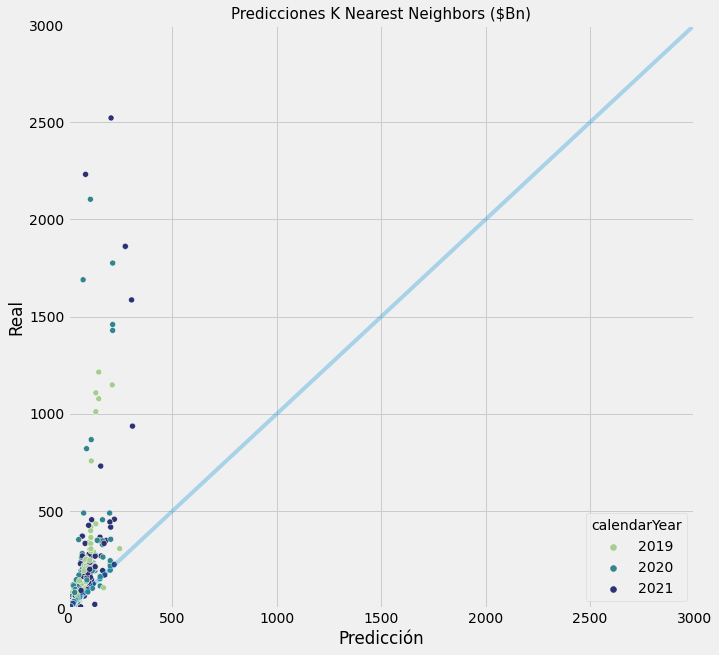

In [86]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='knn', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 3000, 0, 3000])
ax.set_title('Predicciones K Nearest Neighbors ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/knn.jpg', bbox_inches = 'tight')

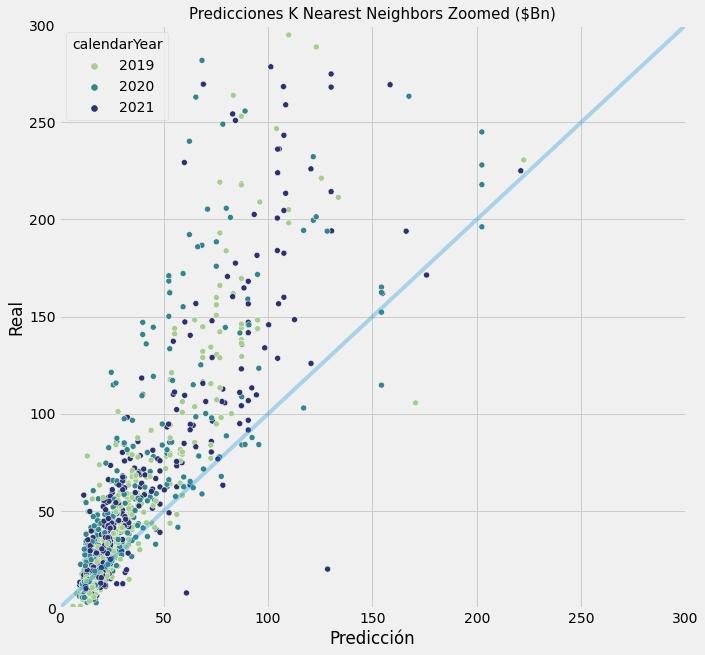

In [100]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='knn', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 300, 0, 300])
ax.set_title('Predicciones K Nearest Neighbors Zoomed ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/knn_zoomed.jpg', bbox_inches = 'tight')

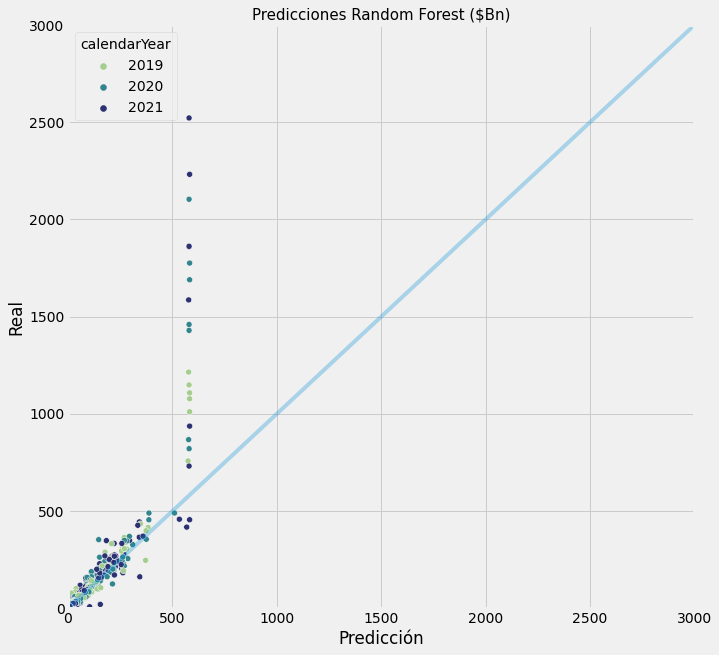

In [89]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='rf', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 3000, 0, 3000])
ax.set_title('Predicciones Random Forest ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/rf.jpg', bbox_inches = 'tight')

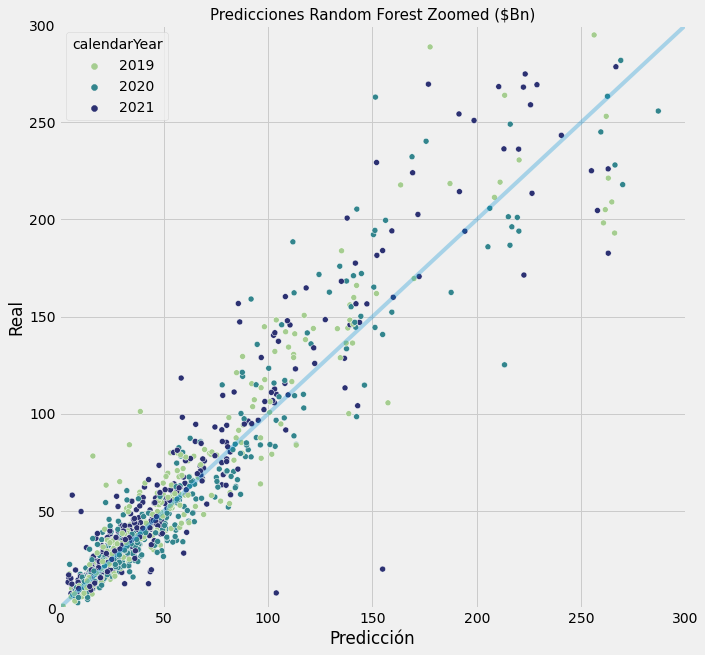

In [94]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='rf', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 300, 0, 300])
ax.set_title('Predicciones Random Forest Zoomed ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/rf_zoomed.jpg', bbox_inches = 'tight')

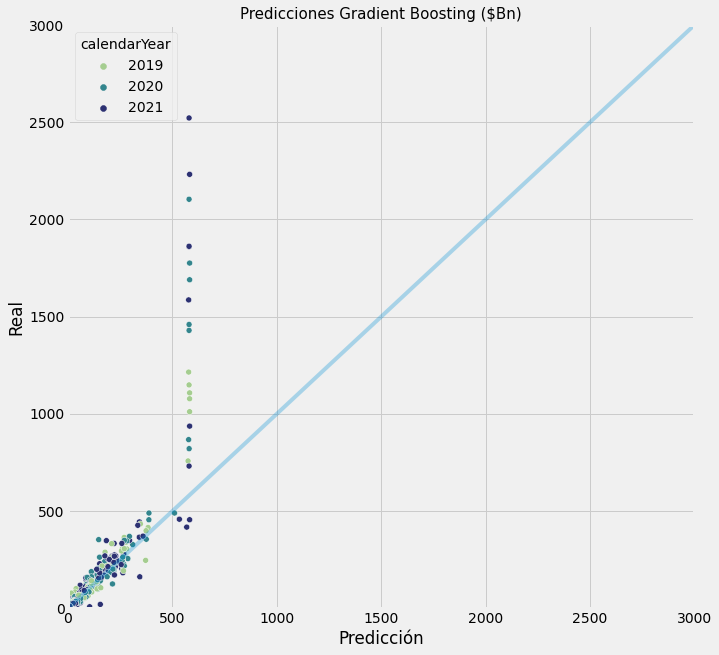

In [97]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='rf', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 3000, 0, 3000])
ax.set_title('Predicciones Gradient Boosting ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/xgb.jpg', bbox_inches = 'tight')

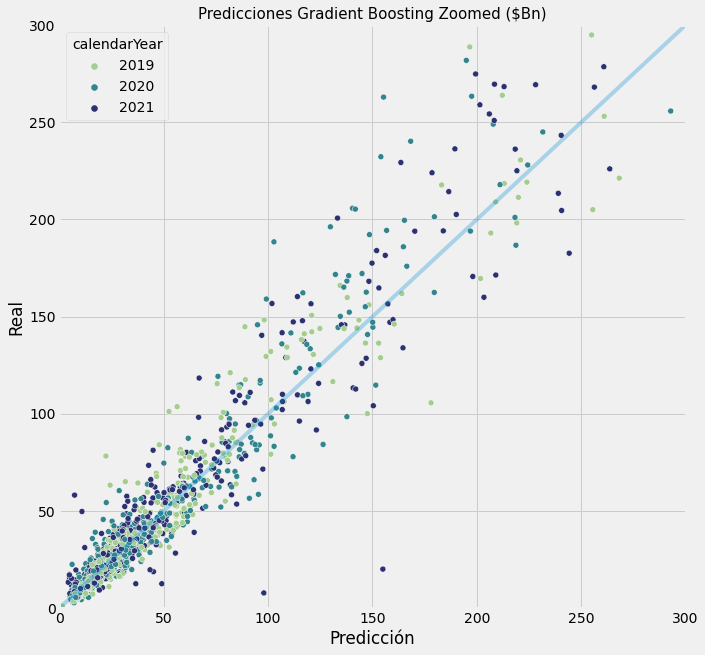

In [99]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = future_data, y='target', x='xgb', hue='calendarYear', palette='crest')
plt.plot([0,4000], [0,4000], alpha = 0.3)
plt.axis([0, 300, 0, 300])
ax.set_title('Predicciones Gradient Boosting Zoomed ($Bn)', fontsize = 15)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig('../../ppt/images/xgb_zoomed.jpg', bbox_inches = 'tight')

In [26]:
future_data['ensemble_LrRfXgb'] = (future_data.lr + future_data.xgb + future_data.rf)/3
mean_absolute_error(y_true=future_data.target, y_pred = future_data.ensemble_LrRfXgb)

20.981540478689826

In [27]:
importances = pd.DataFrame(zip(future_features.columns,xgb_pipe[-1].feature_importances_), columns=['feature', 'importance']).sort_values('importance', ascending = False)

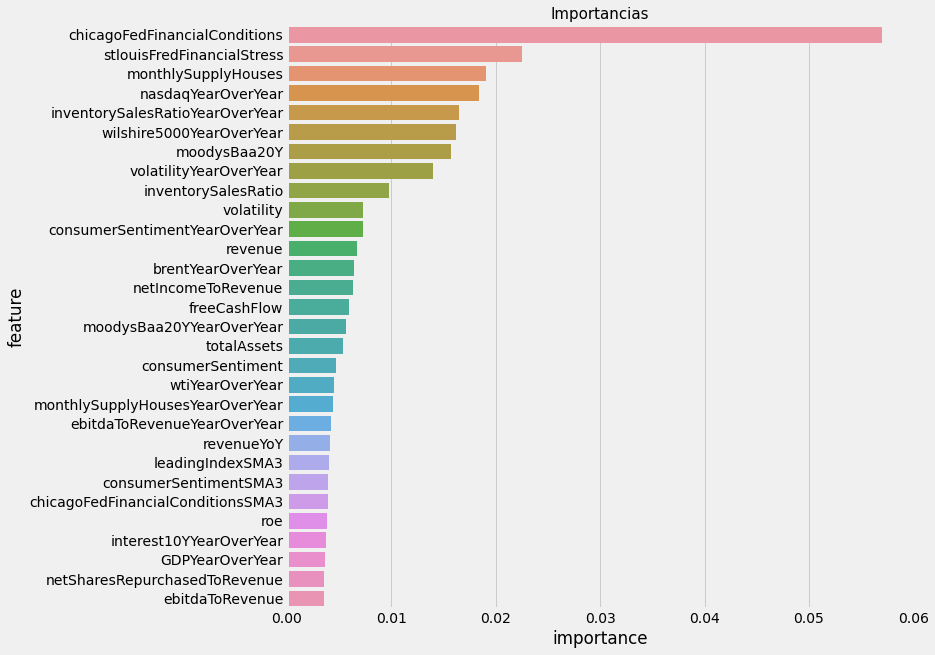

In [71]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.barplot(data = importances[1:31], x='importance', y = 'feature', orient='h')
ax.set_title('Importancias', fontsize = 15)
plt.xlim(0,0.06)
plt.savefig('../../ppt/images/importances_no_mcap.jpg', bbox_inches = 'tight')

In [250]:
data_2021 = future_data.query("calendarYear == 2021").copy()

In [251]:
data_2021.loc[:,'xgb_gain'] = (data_2021.xgb - data_2021.target)/data_2021.target

In [258]:
cols = ['target', 'xgb', 'xgb_gain', 'symbol']
data_2021[cols].sort_values(by='xgb_gain').head(20)

,target,xgb,xgb_gain,symbol
933,58.22069,7.36317,-0.87353,MRNA
1027,49.79522,10.89892,-0.78113,NXPI
11,2522.28195,653.90790,-0.74075,AAPL
945,2232.30744,586.60352,-0.73722,MSFT
1304,17.14797,4.88907,-0.71489,TRMB
334,15.67176,4.96726,-0.68304,CRL
1130,13.39471,4.32715,-0.67695,PTC
606,1862.05763,683.01733,-0.63319,GOOGL
603,1860.82749,683.01733,-0.63295,GOOG
1203,15.39484,5.87715,-0.61824,SEDG


In [260]:
cols = ['target', 'xgb', 'xgb_gain', 'symbol']
data_2021[cols].sort_values(by='xgb_gain', ascending = False).head(20)

,target,xgb,xgb_gain,symbol
1068,7.90313,97.99921,11.40005,PENN
929,20.16374,155.01213,6.68767,MPWR
399,12.63536,49.12970,2.88827,DISCA
402,12.63595,36.67652,1.90255,DISCK
209,18.84573,45.14384,1.39544,BRO
1381,19.80261,43.50381,1.19687,VIAC
726,6.63404,14.21022,1.14202,IPGP
1142,162.02229,332.72641,1.05358,PYPL
1460,9.39054,19.22259,1.04702,WYNN
1326,28.38955,55.68047,0.96130,TWTR


#### KMeans
- Inconclusive Results

In [86]:
clusters = []
inertias = []
ch_scores = []
sil_scores = []

pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer())
    ]
)
data = pipe.fit_transform(X_train)
for a in range(2,20):
    print(a)
    kmeans = KMeans(n_clusters=a)
    kmeans.fit(data)
    clusters.append(a)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, kmeans.labels_))
    sil_scores.append(silhouette_score(data, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


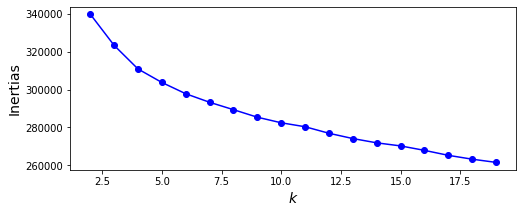

In [90]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertias", fontsize=14)
plt.show()

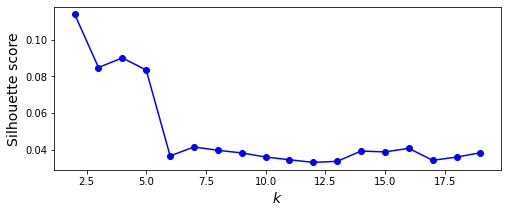

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

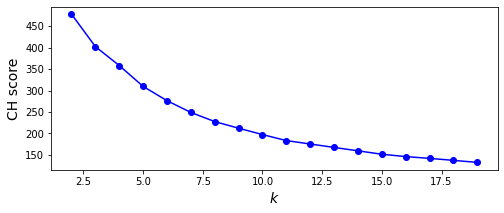

In [92]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, ch_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("CH score", fontsize=14)
plt.show()

-> This does not do what I want, I want to transform each observation to de distance to its centroid.

# v2
- clipping the the previousMarketCap feature destroys outliers. 
  - Filter clipping by kurtosis??
  - Predict Increases??

### Try to predict separating train on test based on time

In [61]:
features_gt_2016 = data.query("calendarYear > 2016").drop(columns=['target','targetYoY', 'symbol', 'calendarYear', 'fillingDate'])
target_gt_2016 = np.log(data.query("calendarYear > 2016").target)
X_test, y_test = shuffle(features_gt_2016, target_gt_2016)
X_test.shape, y_test.shape

((967, 142), (967,))

In [62]:
features_let_2016 = data.query("calendarYear <= 2016").drop(columns=['target','targetYoY', 'symbol', 'calendarYear', 'fillingDate'])
target_let_2016 = np.log(data.query("calendarYear <= 2016").target)
X_train, y_train = shuffle(features_let_2016, target_let_2016)
X_train.shape, y_train.shape

((5351, 142), (5351,))

In [63]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [57]:
def search_boosting(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', xgboost.XGBRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mse

    minutes = 20
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [58]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, X_train, X_test, y_train, y_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 511.54083351266894
mse test:  2757.878836447736
rmse test:  52.51551043689603


- At least we've managed to replicate the problem, now we have something we can work with

In [49]:
results, study = search_boosting(mypipe, X_train, X_test, y_train, y_test)

[I 2022-04-20 11:07:18,810] A new study created in memory with name: no-name-4c1c911c-976b-47d6-8c92-3a0cecac1b2c
[W 2022-04-20 11:07:18,816] Trial 0 failed because of the following error: NameError("name 'XGBRegressor' is not defined")
Traceback (most recent call last):
  File "C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\fpala\AppData\Local\Temp\ipykernel_8916\501300347.py", line 16, in objective
    ('xgb', XGBRegressor(**params)),
NameError: name 'XGBRegressor' is not defined


NameError: name 'XGBRegressor' is not defined

In [20]:
study.best_trial.value, study.best_trial.params

(1229.970786942123,
 {'min_child_weight': 21,
  'alpha': 4.942615434527387e-06,
  'max_depth': 13,
  'colsample_bytree': 0.9188509285361383,
  'subsample': 0.8928671489358959,
  'eta': 0.16142476850744988})

In [21]:
params =  {
    'min_child_weight': 21,
    'alpha': 4.942615434527387e-06,
    'max_depth': 13,
    'colsample_bytree': 0.9188509285361383,
    'subsample': 0.8928671489358959,
    'eta': 0.16142476850744988
  }
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(features_train,target_train)
preds_test = pipe.predict(features_test)
preds_train = pipe.predict(features_train)
mse_test = mean_squared_error(y_true=np.exp(target_test), y_pred=np.exp(preds_test))
mse_train = mean_squared_error(y_true=np.exp(target_train), y_pred=np.exp(preds_train))

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [22]:
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))

mse train: 14.273936728016926
mse test:  1229.970786942123
rmse test:  35.07093935072346


Brutal overfit? let's check

In [28]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target'])
future_target = future_data.target
preds = pipe.predict(future_features)
mse = mean_squared_error(y_true=future_target, y_pred=np.exp(preds))

In [30]:
r2_score(y_true=future_target, y_pred=np.exp(preds))

0.5459493656515411

In [35]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'netDebt']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,error
11,AAPL,2021,2021-10-28,2522.28195,580.82471,2104.10094,358.01966,0.01585,-67.11231,-1941.45724
945,MSFT,2021,2021-07-29,2232.30744,586.79883,1689.97110,343.44115,0.17094,-70.52696,-1645.50861
10,AAPL,2020,2020-10-30,2104.10094,508.75714,1215.20182,342.59619,0.04621,-83.97965,-1595.34380
108,AMZN,2020,2021-02-03,1775.95251,438.52985,1077.89170,338.67049,0.16361,-0.00738,-1337.42267
606,GOOGL,2021,2022-02-02,1862.05763,535.41132,1429.52317,361.12663,0.53298,-141.53104,-1326.64631
...,...,...,...,...,...,...,...,...,...,...
1267,T,2021,2022-02-16,171.42955,232.91690,217.93919,554.47522,0.07677,172.39983,61.48735
1012,NVDA,2019,2019-02-21,105.69150,180.86304,167.92988,14.44950,0.94524,-5.90680,75.17154
1068,PENN,2021,2022-02-28,7.90313,92.74256,114.87510,16.96024,-0.00510,5.81491,84.83943
929,MPWR,2021,2022-02-25,20.16374,127.15799,169.41610,1.59503,0.26775,-0.72883,106.99425


<AxesSubplot:xlabel='predicted', ylabel='real'>

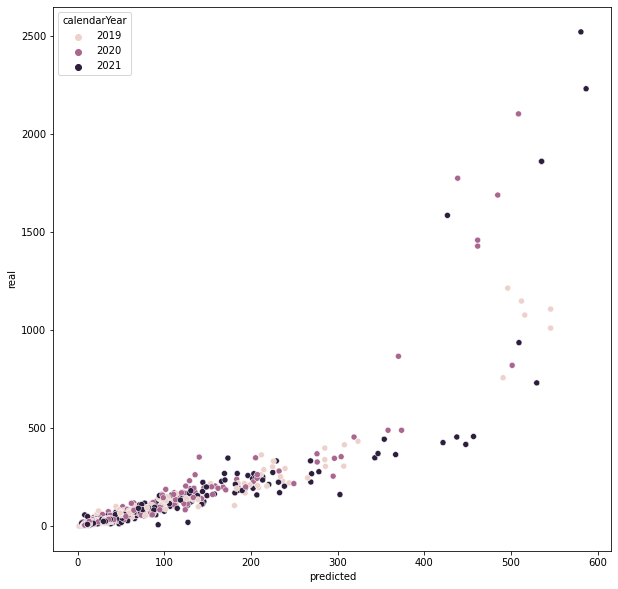

In [36]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = df_predictions, x= 'predicted', y='real', hue='calendarYear')

In [37]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
66,previousMarketCap,0.52610
70,freeCashFlow,0.08101
1,chicagoFedFinancialConditions,0.02705
42,wilshire5000YearOverYear,0.02586
16,nasdaq,0.02312
38,nasdaqYearOverYear,0.01811
32,inventorySalesRatioYearOverYear,0.01732
67,totalAssets,0.01175
17,stlouisFredFinancialStress,0.01060
26,GDPYearOverYear,0.00901


## Attempt to predict increases instead of absolute values

In [ ]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_absolute_error(y_true=y_test, y_pred=preds_test)
    mse_train = mean_absolute_error(y_true=y_train, y_pred=preds_train)
    print('mse train:', mse_train)
    print('mse test: ', mse_test)

In [ ]:
def search_boosting(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mae")
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(n**params, )),
            ])
        dvalid = xgb.DMatrix(valid_x, label=valid_y)
        pipe.fit(X_train,y_train, evals=[(dvalid, "validation")])
        preds = pipe.predict(X_test)
        mse = mean_absolute_error(y_true=y_test, y_pred=preds)
        return mse

    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [63]:
data = pd.read_csv('../data/processed/present.csv')
data.query("calendarYear >= 2016").shape, data.query("calendarYear < 2016").shape

((1435, 147), (4883, 147))

In [64]:
features_test = data.query("calendarYear > 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate', 'targetYoY'])
target_test = data.query("calendarYear > 2016").targetYoY
features_train = data.query("calendarYear <= 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate', 'targetYoY'])
target_train = data.query("calendarYear <= 2016").targetYoY

In [65]:
[a.shape for a in [features_train, features_test, target_train, target_test]]

[(5351, 142), (967, 142), (5351,), (967,)]

In [66]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, features_train, features_test, target_train, target_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 0.22286622398624073
mse test:  0.22684901734416765


In [68]:
results, study = search_boosting(mypipe, features_train, features_test, target_train, target_test)

[I 2022-04-20 02:15:57,144] A new study created in memory with name: no-name-79e5ee6d-c68b-47df-bee6-5538aeafd15b
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 02:16:01,329] Trial 0 finished with value: 0.2041646297927524 and parameters: {'min_child_weight': 285, 'alpha': 3.1450381164535973e-06, 'max_depth': 5, 'colsample_bytree': 0.9265000936173176, 'subsample': 0.8498257214705593, 'eta': 0.10857295304586415}. Best is trial 0 with value: 0.2041646297927524.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 02:16:05,773] Trial 1 finished with value: 0.20592682351623676 and parameters: {'min_child_weight': 202, 'alpha': 0.4493203943733698, '

In [69]:
study.best_trial.value, study.best_trial.params

(0.1976961636954313,
 {'min_child_weight': 97,
  'alpha': 1.0797968706087468e-05,
  'max_depth': 10,
  'colsample_bytree': 0.9543659397032849,
  'subsample': 0.753398775048909,
  'eta': 0.0719481709483498})

In [79]:
params =  {'min_child_weight': 97,
  'alpha': 1.0797968706087468e-05,
  'max_depth': 10,
  'colsample_bytree': 0.9543659397032849,
  'subsample': 0.753398775048909,
  'eta': 0.0719481709483498}
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(features_train,target_train)
preds_test = pipe.predict(features_test)
preds_train = pipe.predict(features_train)
mse_test = mean_squared_error(y_true=target_test, y_pred=preds_test)
mse_train = mean_squared_error(y_true=target_train, y_pred=preds_train)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [80]:
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))

mse train: 0.13625708537923498
mse test:  0.10779080531802686
rmse test:  0.3283151006548844


In [81]:
r2_score(y_true=target_train, y_pred=preds_train)

0.5439956778950903

mejor!

In [82]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target', 'targetYoY'])
future_target = future_data.targetYoY
preds = pipe.predict(future_features)
mean_absolute_error(y_true=future_target, y_pred=preds)

0.22826146667541938

In [83]:
r2_score(y_true=future_target, y_pred=preds)

0.1770036983293396

In [84]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'netDebt', 'target']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error
1298,TMUS,2019,2020-02-06,4.99261,2.42773,13.07212,93.00749,-0.10162,13.58808,78.33611,-2.56488
1279,TER,2020,2021-02-22,5.02846,2.48794,3.74679,3.85205,0.10605,-1.58210,22.58738,-2.54053
807,LDOS,2019,2020-02-18,4.36652,2.07497,3.30424,10.18300,0.09565,2.49903,17.73228,-2.29155
1130,PTC,2021,2021-11-22,3.56784,3.06752,2.93239,4.59867,0.09197,1.34816,13.39471,-0.50032
701,IFF,2020,2021-02-22,1.51948,1.14738,14.24177,13.53788,0.32371,0.69844,35.88190,-0.37210
...,...,...,...,...,...,...,...,...,...,...,...
964,NCLH,2020,2021-02-26,-0.01850,2.17428,8.84793,19.40133,-0.01606,8.96838,8.68425,2.19278
1460,WYNN,2021,2022-02-28,-0.37359,1.82048,14.99101,12.59662,-0.18258,9.64199,9.39054,2.19407
979,NI,2020,2021-02-17,-0.22041,2.07406,11.67339,23.24061,-0.08009,9.88778,9.10042,2.29448
1133,PVH,2021,2021-03-31,1.64510,4.25750,2.87267,13.98695,0.27178,3.95112,7.59850,2.61240


In [88]:
df_predictions['predictedMarketCap'] = df_predictions.previousMarketCap * df_predictions.predicted

In [96]:
df_predictions

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error,predictedMarketCap
0,A,2019,2019-12-19,0.20543,1.22422,23.50679,10.14027,-0.00190,0.99011,28.33586,1.01879,28.77753
1,A,2020,2020-12-18,0.37102,1.26708,28.33586,10.18350,0.00841,0.63674,38.84897,0.89606,35.90381
2,A,2021,2021-11-22,0.22534,1.28936,38.84897,10.86931,0.03251,0.98378,47.60321,1.06402,50.09013
3,AAL,2019,2020-02-19,-0.26895,1.15752,16.97603,64.19635,0.03774,31.69161,12.41028,1.42648,19.65017
4,AAL,2020,2021-02-17,-0.04930,1.62125,12.41028,65.38252,-0.10747,36.01530,11.79842,1.67055,20.12010
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,ZION,2020,2021-02-25,0.22668,1.48187,7.71797,85.91283,0.05288,-34.86389,9.46747,1.25519,11.43699
1490,ZION,2021,2022-02-25,0.07593,1.01630,9.46747,93.68290,0.05553,-59.38347,10.18633,0.94038,9.62183
1491,ZTS,2019,2019-12-31,0.42571,1.06045,47.56083,12.35429,0.38342,5.00658,67.80811,0.63474,50.43593
1492,ZTS,2020,2021-02-16,0.20407,1.28679,67.80811,14.35039,0.41580,3.96456,81.64559,1.08272,87.25463


In [101]:
df_predictions.sort_values(by='error').head(100)

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error,predictedMarketCap
1298,TMUS,2019,2020-02-06,4.99261,2.42773,13.07212,93.00749,-0.10162,13.58808,78.33611,-2.56488,31.73554
1279,TER,2020,2021-02-22,5.02846,2.48794,3.74679,3.85205,0.10605,-1.58210,22.58738,-2.54053,9.32178
807,LDOS,2019,2020-02-18,4.36652,2.07497,3.30424,10.18300,0.09565,2.49903,17.73228,-2.29155,6.85620
1130,PTC,2021,2021-11-22,3.56784,3.06752,2.93239,4.59867,0.09197,1.34816,13.39471,-0.50032,8.99517
701,IFF,2020,2021-02-22,1.51948,1.14738,14.24177,13.53788,0.32371,0.69844,35.88190,-0.37210,16.34079
610,GPN,2019,2020-02-21,1.93400,1.60044,21.59482,47.59529,0.05245,8.55932,63.35929,-0.33356,34.56122
401,DISCK,2020,2021-02-22,1.27576,1.07829,14.45164,35.94249,0.25062,13.50271,32.88852,-0.19748,15.58301
541,FIS,2019,2020-02-20,1.65585,1.49509,38.11796,89.67440,0.04965,20.51105,101.23552,-0.16076,56.98990
73,ALGN,2020,2021-02-26,1.39065,1.26045,19.12471,5.09344,0.45870,-0.92225,45.72044,-0.13019,24.10582
92,AMD,2019,2020-02-04,1.36249,1.37927,27.57630,6.45103,-1.17682,-1.10425,65.14876,0.01677,38.03504


<AxesSubplot:xlabel='predicted', ylabel='real'>

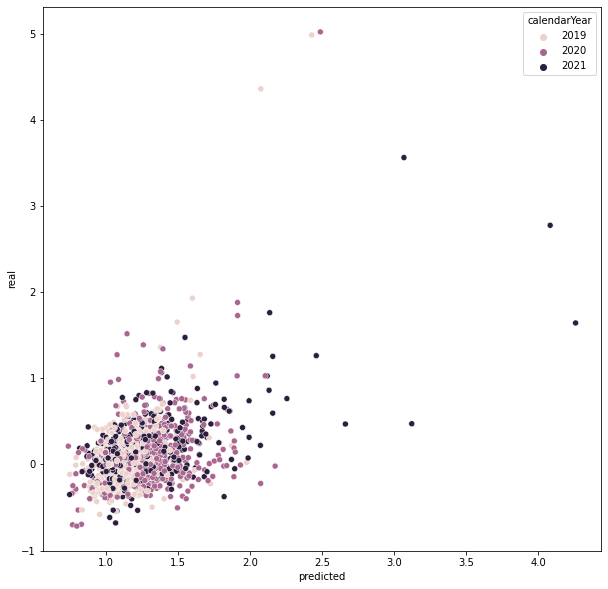

In [86]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = df_predictions, x= 'predicted', y='real', hue='calendarYear')

In [102]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
32,inventorySalesRatioYearOverYear,0.11715
42,wilshire5000YearOverYear,0.08198
38,nasdaqYearOverYear,0.05003
99,operatingIncomeToRevenue,0.03095
129,dividendsPaidToRevenueYearOverYear,0.02966
55,leadingIndexSMA3,0.02845
10,inventorySalesRatio,0.02771
24,consumerSentimentYearOverYear,0.02658
66,previousMarketCap,0.02518
92,retainedEarningsToAssets,0.02337


# v3: Building a model generator pipeline
- Streamline to try on different algorithms, features, target, etc
- Check correlation between results and build different estimators that predict different things with different features

### Input data

In [59]:
features_gt_2016 = data.query("calendarYear > 2016").drop(columns=['target','targetYoY', 'symbol', 'calendarYear', 'fillingDate'])
target_gt_2016 = np.log(data.query("calendarYear > 2016").target)
X_test, y_test = shuffle(features_gt_2016, target_gt_2016)
X_test.shape, y_test.shape

((967, 142), (967,))

In [60]:
features_let_2016 = data.query("calendarYear <= 2016").drop(columns=['target','targetYoY', 'symbol', 'calendarYear', 'fillingDate'])
target_let_2016 = np.log(data.query("calendarYear <= 2016").target)
X_train, y_train = shuffle(features_let_2016, target_let_2016)
X_train.shape, y_train.shape

((5351, 142), (5351,))

In [ ]:
voting_pipe = Pipeline(
    steps=[
        ('',),
        ('',),
        ('',),
    ]
) 

In [51]:
def model_stack_search(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', xgboost.XGBRegressor(n_estimators = 1000, **params)),
            ])
        dvalid = xgboost.DMatrix(X_test, label=y_test)
        callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mae")
        pipe.fit(X_train,y_train, evals=[(dvalid, "validation")], callbacks = [callback])
        preds = pipe.predict(X_test)
        mse = mean_absolute_error(y_true=y_test, y_pred=preds)
        return mse

    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study